In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.distributions import Normal
from scipy.linalg import block_diag
from numpy.linalg import inv
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import numpy.matlib as nm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
def get_lstm_params(num_inputs, num_hiddens, num_outputs, num_units):
    
    def normal(shape):
        return Variable(nn.Parameter(torch.randn(size = shape))) * 0.01
    def zero(shape):
        return Variable(nn.Parameter(torch.zeros(shape)))
    def three(num_inputs, num_hiddens, num_outputs):
        return (normal((num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), zero(num_hiddens))
    
    W_xi, W_hi, b_i = three(num_inputs, num_hiddens, num_outputs) # 输入门参数
    W_xf, W_hf, b_f = three(num_inputs, num_hiddens, num_outputs) # 遗忘门参数
    W_xo, W_ho, b_o = three(num_inputs, num_hiddens, num_outputs) # 输出门参数
    W_xc, W_hc, b_c = three(num_inputs, num_hiddens, num_outputs) # 候选记忆门参数
    
    # 输出层参数
    W_hq = normal((num_units, num_hiddens, num_outputs))
    
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq]
    for param in params:
        param.requires_grad_(True)
    
    return params 

In [3]:
def init_lstm_state(batch_size, num_hiddens):
    return (torch.ones(batch_size, num_hiddens)*(-20.0), 
            torch.ones(batch_size, num_hiddens)*(-20.0))

In [4]:
def lstm(inputs, state, unit_index, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    W_hq = params[12][unit_index]
    (H, C) = state
    
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        Y = H @ W_hq
        outputs.append(Y)

    return torch.cat(outputs, dim = 0)

In [5]:
class RNNModelScratch():
    def __init__(self, num_inputs, num_hiddens, num_outputs, 
                 num_units, get_params, init_state, forward_fn):   
        self.num_inputs, self.num_hiddens = num_inputs, num_hiddens
        self.num_outputs, self.num_units = num_outputs, num_units
        self.params = get_params(num_inputs, num_hiddens, num_outputs, num_units)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state, unit_index):
        return self.forward_fn(X, state, unit_index, self.params)
    
    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [6]:
class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2  # 转化为距离矩阵
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, historical_grad, lnprob, n_iter, stepsize, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        # historical_grad = 0
        # for iter in range(n_iter):
        #    if debug and (iter+1) % 1000 == 0:
        #        print('iter ' + str(iter+1))
            
        lnpgrad = lnprob(theta)
        # calculating the kernel matrix
        kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
        grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  

        # adagrad 
        if n_iter == 0:
            historical_grad = historical_grad + grad_theta ** 2
        historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
        
        adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
        # theta = theta + stepsize * adj_grad 
            
        return adj_grad, historical_grad

In [7]:
class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A # 协方差的逆矩阵
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)

In [8]:
def train(net, lr, num_epochs, inputs, targets, batch_size, model, step_size, valid_obv):
    # train(net, lr, num_epochs, X, train_data, batch_size, model, step_size, valid_obv)
    loss = nn.MSELoss()
    updater = optim.Adam(net.params, lr)
    num_unit = len(inputs)
    
    historical_grad = 0
    loss_lt = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        L = torch.zeros(num_unit)      
        for i in range(num_unit):
            tmp_obv = valid_obv[i]
            state = net.begin_state(batch_size)
            y_preb = net(inputs[i], state, i)
            L[i] = loss(y_preb[tmp_obv], targets[i][tmp_obv])
        
        tmp_gamma = net.params[12].detach().permute(0,2,1).numpy().reshape(num_unit, -1)
        grad, historical_grad = SVGD().update(tmp_gamma, historical_grad, model.dlnprob, epoch, step_size)
        
        loss_lt[epoch] = L.mean().item()
        updater.zero_grad()
        L.mean().backward()
        updater.step()
        
        net.params[12].data += step_size * torch.tensor(grad.reshape(num_unit,3,num_sensors), dtype=torch.float)
        # net.params[12] = torch.tensor(net.params[12].detach().numpy(), dtype=torch.float, requires_grad=True)
        
        if epoch % 10 == 0:
            print('epoch:{}/{}'.format(epoch+1, num_epochs))
            print('Loss:', L.mean().item())

    print('finished training!')

    return loss_lt

In [9]:
# A = np.diag(np.ones(18))
# mu = np.zeros(18)

A = np.load('cov1.npy')
mu = np.load('mu1.npy').reshape(-1)

model1 = MVN(mu, A)

In [10]:
#  读入训练数据
df_train = pd.read_csv('train_data.csv')
num_units = df_train['Unit'].max()
num_train = 20
num_sensors = 6

np.random.seed(111)
selected_unit = np.random.choice(num_units, num_train, replace=False)

t = [torch.tensor([i/500.0]) for i in range(500)]
T = []
train_data = []
lengths = []

for i in selected_unit:
    sensor_data = torch.tensor(df_train[df_train['Unit'] == i+1].iloc[:,2:].values, dtype = torch.float)  
    T.append(t[:sensor_data.shape[0]])
    train_data.append(sensor_data)
    lengths.append(len(sensor_data)) 

In [11]:
num_inputs = 1
num_hiddens = 3
num_outputs = 6
net = RNNModelScratch(num_inputs, num_hiddens, num_outputs, num_train, get_lstm_params, init_lstm_state, lstm)
net.params = torch.load('LSTM-SVGD(20)-1.pth')

In [12]:
def get_H(inputs, params, num_hiddens):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    (H, C) = init_lstm_state(1, num_hiddens)
    H_lt = torch.zeros((len(inputs), num_hiddens))
    for i in range(len(inputs)):
        X = inputs[i]
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        
        H_lt[i] = H
    
    return H_lt

In [13]:
def predict_sensors(net, inputs, targets, unit_index): 
    fig = plt.figure(figsize=(15,5))
    state = net.begin_state(1)
    y_preb = net(inputs, state, unit_index)
    
    for i in range(6):
        plt.subplot(2, 3, 1+i)
        plt.plot(targets[8:,i], 'o', alpha=0.5)
        plt.plot(y_preb[8:,i].detach().numpy(), color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

In [14]:
def predict_sensors2(targets, unit_index, valid_len): 
    fig = plt.figure(figsize=(12,4))
    tmp_Psi = Psi[:valid_len]
    y_pred = tmp_Psi @ gamma[unit_index].T
    
    for i in range(6):
        plt.subplot(2, 3, 1+i)
        t1 = np.arange(len(targets))
        t2 = np.arange(len(tmp_Psi))
        plt.plot(t1[8:], targets[8:,i], '.', markersize=3)
        plt.plot(t2[8:], y_pred[8:,i], color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

In [30]:
# num_train = 20
Psi = get_H(t, net.params, num_hiddens).detach().numpy()

tmp_gamma = net.params[12].detach().numpy()
gamma = np.zeros((num_train, num_sensors, num_hiddens))
for i in range(num_train):
    gamma[i] = tmp_gamma[i].T
    
Psi.shape, gamma.shape

((500, 3), (20, 6, 3))

In [16]:
np.save('Psi-20-1.npy',Psi)
np.save('gamma.npy',gamma)

In [17]:
# 计算传感器噪声方差
sigma2 = np.zeros(num_sensors)

for i in range(num_sensors):
    tmp_sigma2 = 0
    tmp_m = 0
    for j in range(num_train):
        gamma_j = gamma[j,i]
        sensor_data = train_data[j][:,i].detach().numpy()
        tmp_n = lengths[j]
        
        tmp_Psi = Psi[:tmp_n]
        sensor_path = tmp_Psi @ gamma_j
        
        tmp_sigma2 += np.power(sensor_path - sensor_data, 2).sum()
        tmp_m += (tmp_n - 6)
        
    sigma2[i] = tmp_sigma2/tmp_m
sigma2

array([0.09367524, 0.06543641, 0.06773338, 0.06035353, 0.09372196,
       0.08276461])

In [18]:
# gamma的均值和协方差
cov_list = []
for i in range(num_sensors):
    data_i = gamma[:,i]
    cov_i = np.cov(data_i.T)
    cov_list.append(cov_i)
    
cov = block_diag(cov_list[0],cov_list[1],cov_list[2],cov_list[3],cov_list[4],cov_list[5])
# cov = np.cov(gamma.reshape(num_train,-1).T)
mu = gamma.reshape(num_train,-1).mean(axis=0).reshape(-1,1)

cov.shape, mu.shape

((18, 18), (18, 1))

In [19]:
# num_train = 100

mu_i = np.zeros((num_train, 3*num_sensors,1)) 
cov_i = np.zeros((num_train,3*num_sensors,3*num_sensors))

for i in range(num_train):
    tmp_n = lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = train_data[i].detach().numpy().T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_i[i] = tmp_mu
    cov_i[i] = tmp_cov

In [19]:
np.save('cov.npy',cov_i)
np.save('mu.npy',mu_i)

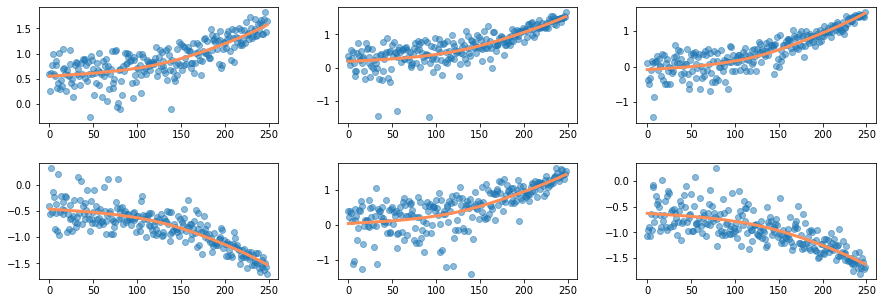

In [20]:
unit_index = 1
predict_sensors(net, T[unit_index], train_data[unit_index], unit_index)

In [21]:
lam, Th = 0.1, 0.8 # 大于Th的时间点被认为是异常点
valid_obv = []
    
for i in range(num_train):
    unit_i = selected_unit[i] 
    L = df_train[df_train['Unit'] == unit_i+1].iloc[:,2:].values
    tmp_n, q = lengths[i], 2
    tmp_Psi = Psi[:tmp_n]

    # 初始化
    H = tmp_Psi @ inv(tmp_Psi.T @ tmp_Psi + 1e-6*np.diag(np.ones(tmp_Psi.shape[1]))) @ tmp_Psi.T
    X = np.eye(H.shape[0]) - H


    Y = X @ L
    gamma = inv(X.T @ X + lam*np.eye(X.shape[0])) @ X.T @ Y
    R = np.zeros(gamma.shape[0])

    for j in range(gamma.shape[0]):
        tmp_gamma = gamma[j].reshape(1,-1)
        R[j] = tmp_gamma @ tmp_gamma.T

    # update
    valid_obv.append(np.where(R<Th))

In [22]:
unit_index = 1
 
L = train_data[unit_index].detach().numpy()
tmp_n, q = lengths[unit_index], 2
tmp_Psi = Psi[:tmp_n]

# 初始化
H = tmp_Psi @ inv(tmp_Psi.T @ tmp_Psi + 1e-6*np.diag(np.ones(tmp_Psi.shape[1]))) @ tmp_Psi.T
X = np.eye(H.shape[0]) - H


Y = X @ L
gamma = inv(X.T @ X + lam*np.eye(X.shape[0])) @ X.T @ Y
R = np.zeros(gamma.shape[0])

for j in range(gamma.shape[0]):
    tmp_gamma = gamma[j].reshape(1,-1)
    R[j] = tmp_gamma @ tmp_gamma.T
    
obv_index1 = np.array(np.where(R>=Th)).reshape(-1)
obv_index2 = np.array(np.where(R<Th)).reshape(-1)

In [23]:
K = 200
gamma_samples = np.random.multivariate_normal(mu_i[unit_index].flatten(), cov_i[unit_index], size=K)  

In [24]:
sensor_path = np.zeros((K,320,6))
for k in range(K):
    sensor_path[k] = Psi[:320] @ gamma_samples[k].reshape(num_sensors,-1).T

In [28]:
tmp_Psi.shape

(257, 3)

In [29]:
gamma[unit_index].shape

(6,)

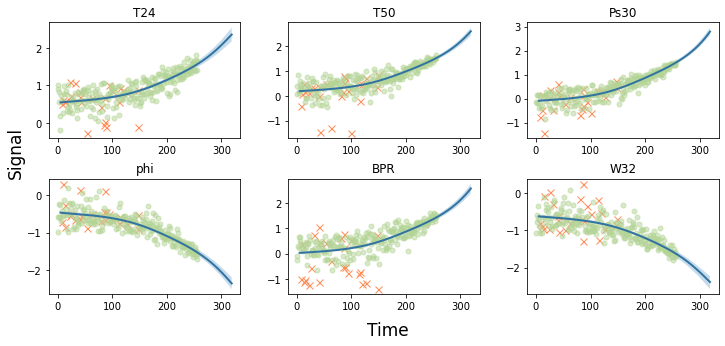

In [31]:
targets, valid_len = train_data[unit_index], lengths[unit_index]

fig = plt.figure(figsize=(12,5))
tmp_Psi = Psi[:valid_len]
y_pred = tmp_Psi @ gamma[unit_index].T

sensor_index = ['T24','T50','Ps30','phi','BPR','W32']

for i in range(6):
    plt.subplot(2, 3, 1+i)
    t1 = np.arange(len(tmp_Psi))
    t2 = np.arange(320)
    plt.plot(obv_index1, targets[obv_index1,i], 'x', color='#FF8D57', markersize=7, label='Outlier')
    plt.plot(obv_index2, targets[obv_index2,i], 'o', color='#B3D495', markersize=5, alpha=0.5, label='Selected sensor signal')
    plt.title(sensor_index[i])
    
    # plt.plot(t2[5:], sensor_path[5:,i], color='#3274A1', linewidth = 0.2) # #AECCDB    
    plt.plot(t2[5:], sensor_path.mean(axis=0)[5:,i], color='#3274A1', linewidth = 2.0)
    plt.fill_between(t2[5:],np.percentile(sensor_path[:,5:,i],2.5,axis=0), np.percentile(sensor_path[:,5:,i],97.5,axis=0), alpha=0.25)

plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
num1, num2, num3, num4 = -2.6, -0.63, 3, 0
# plt.legend(bbox_to_anchor=(num1, num2), loc=num3, borderaxespad=num4)
plt.text(-310,-3.8,'Time',fontsize=17)
plt.text(-970,0.5,'Signal',fontsize=17, rotation=90)
# plt.savefig('sensor path&outlier2.png', bbox_inches='tight', dpi=2500, transparent=True)
plt.show()

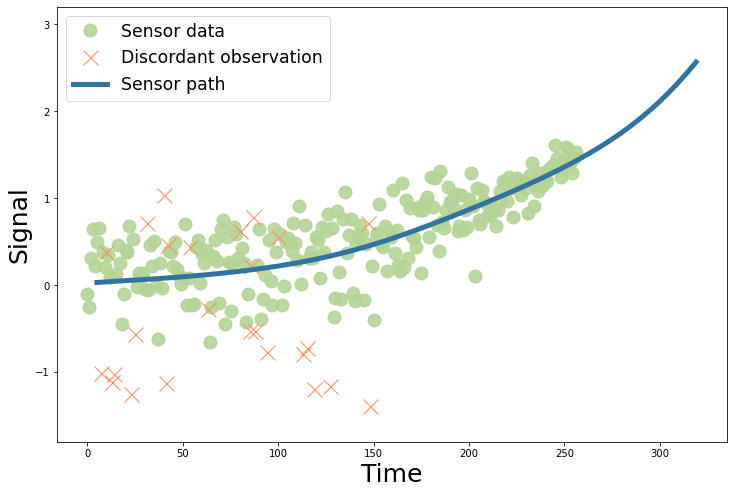

In [33]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

i = 4
t1 = np.arange(len(tmp_Psi))
t2 = np.arange(320)
plt.plot(obv_index2, targets[obv_index2,i], 'o', color='#B3D495', markersize=13, alpha=0.9, label='Sensor data')
plt.plot(obv_index1, targets[obv_index1,i], 'x', color='#FF8D57', markersize=15, label='Discordant observation')
# plt.title(sensor_index[i])

# plt.plot(t2[5:], sensor_path[5:,i], color='#3274A1', linewidth = 0.2) # #AECCDB    
plt.plot(t2[5:], sensor_path.mean(axis=0)[5:,i], color='#3274A1', linewidth = 5.0, label='Sensor path')
# plt.fill_between(t2[5:],np.percentile(sensor_path[:,5:,i],2.5,axis=0), np.percentile(sensor_path[:,5:,i],97.5,axis=0), alpha=0.25)
plt.xlabel('Time',fontsize=25)
plt.ylabel('Signal',fontsize=25)
plt.legend(fontsize='xx-large')
ax.set_ylim(-1.8, 3.2)
plt.savefig('incident_parameter2,png', bbox_inches='tight', dpi=1500, transparent=True)
plt.show()

In [274]:
num_epochs, lr = 300, 0.001
batch_size, step_size = 1, 1e-6
loss_lt = train(net, lr, num_epochs, T, train_data, batch_size, model1, step_size, valid_obv)

epoch:1/300
Loss: 0.04309741035103798
epoch:11/300
Loss: 0.04321466013789177
epoch:21/300
Loss: 0.04312267154455185
epoch:31/300
Loss: 0.04310167580842972
epoch:41/300
Loss: 0.04309956356883049
epoch:51/300
Loss: 0.04309754818677902
epoch:61/300
Loss: 0.043093569576740265
epoch:71/300
Loss: 0.0430925078690052
epoch:81/300
Loss: 0.04309191554784775
epoch:91/300
Loss: 0.043091196566820145
epoch:101/300
Loss: 0.04309052973985672
epoch:111/300
Loss: 0.043089888989925385
epoch:121/300
Loss: 0.04308926314115524
epoch:131/300
Loss: 0.04308862239122391
epoch:141/300
Loss: 0.04308798164129257
epoch:151/300
Loss: 0.04308732599020004
epoch:161/300
Loss: 0.043086666613817215
epoch:171/300
Loss: 0.04308599606156349
epoch:181/300
Loss: 0.043085310608148575
epoch:191/300
Loss: 0.04308461770415306
epoch:201/300
Loss: 0.04308391362428665
epoch:211/300
Loss: 0.04308320954442024
epoch:221/300
Loss: 0.04308248683810234
epoch:231/300
Loss: 0.043081771582365036
epoch:241/300
Loss: 0.043081045150756836
epoch

In [73]:
torch.save(net.params, 'LSTM-SVGD-Pre(20)-1.pth')

In [26]:
t = [torch.tensor([i/500.0]) for i in range(500)]

Psi = get_H(t, net.params, num_hiddens).detach().numpy()

tmp_gamma = net.params[12].detach().numpy()
gamma = np.zeros((num_train, num_sensors, num_hiddens))
for i in range(num_train):
    gamma[i] = tmp_gamma[i].T
    
Psi.shape, gamma.shape

((500, 3), (20, 6, 3))

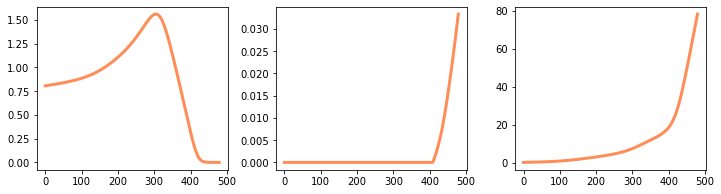

In [27]:
fig = plt.figure(figsize=(12,3))

for i in range(3):
    plt.subplot(1, 3, 1+i)
    plt.plot(Psi[20:,i], color='#FF8D57', linewidth = 3)

plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
plt.show()

In [28]:
# 计算传感器噪声方差
sigma2 = np.zeros(num_sensors)

for i in range(num_sensors):
    tmp_sigma2 = 0
    tmp_m = 0
    for j in range(num_train):
        gamma_j = gamma[j,i]
        sensor_data = train_data[j][:,i].detach().numpy()
        tmp_n = lengths[j]
        
        tmp_Psi = Psi[:tmp_n]
        sensor_path = tmp_Psi @ gamma_j
        
        tmp_sigma2 += np.power(sensor_path - sensor_data, 2).sum()
        tmp_m += (tmp_n - 6)
        
    sigma2[i] = tmp_sigma2/tmp_m
sigma2

array([0.09367524, 0.06543641, 0.06773338, 0.06035353, 0.09372196,
       0.08276461])

In [29]:
# gamma的均值和协方差
cov_list = []
for i in range(num_sensors):
    data_i = gamma[:,i]
    cov_i = np.cov(data_i.T)
    cov_list.append(cov_i)
    
cov = block_diag(cov_list[0],cov_list[1],cov_list[2],cov_list[3],cov_list[4],cov_list[5])
# cov = np.cov(gamma.reshape(num_train,-1).T)
mu = gamma.reshape(num_train,-1).mean(axis=0).reshape(-1,1)

cov.shape, mu.shape

((18, 18), (18, 1))

In [30]:
# num_train = 100

mu_i = np.zeros((num_train, 3*num_sensors,1)) 
cov_i = np.zeros((num_train,3*num_sensors,3*num_sensors))

for i in range(num_train):
    tmp_n = lengths[i]
    obv_list = valid_obv[i]
    tmp_psi = Psi[:tmp_n][obv_list]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),len(obv_list[0]),axis=1).flatten())

    L_i = train_data[i][obv_list].detach().numpy().T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_i[i] = tmp_mu
    cov_i[i] = tmp_cov

In [31]:
# 设置特征值-logistic regression
N, delta, K = 80, 1, 25 # 超参数
inputs = np.zeros((K*num_train,2*N,num_sensors))

for i in range(num_train):
    M = lengths[i]
    gamma_samples = np.random.multivariate_normal(mu_i[i].flatten(), cov_i[i], size=K)  
    
    tt = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        tt[j] = M + (j-N+1) * delta
        
    for k in range(K):
        inputs[i*K+k] = (Psi @ gamma_samples[k].reshape(num_sensors,-1).T)[tt]
        
# 设置标签值
labels = np.hstack((np.zeros(N), np.ones(N))).reshape(1,-1)
# print(label.shape) (1,160)
labels = np.repeat(labels, K*num_train, axis=0)

inputs.shape, labels.shape

((500, 160, 6), (500, 160))

In [62]:
from sklearn.linear_model import LogisticRegression
X_train = inputs.reshape(-1,num_sensors)
Y_train = labels.reshape(-1,1)
X_train.shape, Y_train.shape

model2 = LogisticRegression(penalty="l2", C=0.01, solver="sag", max_iter=1000) #创建模型
model2.fit(X_train, Y_train.ravel()) #训练

LogisticRegression(C=0.01, max_iter=1000, solver='sag')

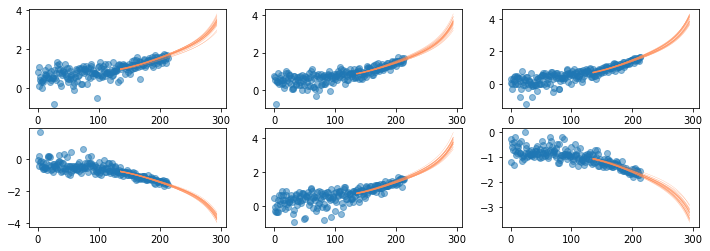

In [268]:
index = 10
sensor_data = train_data[index]

M = lengths[index]
t = torch.zeros(2*N, dtype=torch.long)
for j in range(2*N):
    t[j] = M + (j-N+1) * delta

fig = plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha=0.5)
    for k in range(K):
        sensor_path = inputs[index*K + k]
        plt.plot(t, sensor_path[:,i], color='#FF8D57', linewidth = 0.2)

In [33]:
df_test = pd.read_csv('test_data.csv')
num_test = df_test['Unit'].max()      # 测试数据数量

test_data = []
test_lengths = []
for i in range(num_test):
    Y = np.array(df_test[df_test['Unit']==i+1].iloc[:,2:]) 
    test_data.append(Y)
    test_lengths.append(len(Y))

lam, Th = 0.1, 0.62  
    
updated_data = []
for i in range(num_test):
    L = test_data[i]
    tmp_n, q = test_lengths[i], 2
    tmp_Psi = Psi[:tmp_n]
    
    # B = (inv(tmp_Psi.T @ tmp_Psi) @ tmp_Psi.T @ L).T

    # 初始化
    H = tmp_Psi @ inv(tmp_Psi.T @ tmp_Psi + 1e-6*np.diag(np.ones(3))) @ tmp_Psi.T
    X = np.eye(H.shape[0]) - H

    for epoch in range(5):
        Y = X @ L
        gamma = inv(X.T @ X + lam*np.eye(X.shape[0])) @ X.T @ Y
        R = np.zeros(gamma.shape[0])

        for j in range(gamma.shape[0]):
            tmp_gamma = gamma[j].reshape(1,-1)
            R[j] = tmp_gamma @ tmp_gamma.T

        # update
        L[np.where(R>Th)] = L[np.where(R>Th)] - gamma[np.where(R>Th)] # corrected
     
    updated_data.append(L)
    
mu_j = np.zeros((num_test, num_hiddens*num_sensors,1)) 
cov_j = np.zeros((num_test,num_hiddens*num_sensors,num_hiddens*num_sensors))

for i in range(num_test):
    tmp_n = test_lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = updated_data[i].T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_j[i] = tmp_mu
    cov_j[i] = tmp_cov

mu_j.shape, cov_j.shape

((100, 18, 1), (100, 18, 18))

In [45]:
unit_index, sensor_index = 2, 4 # 1,3,8 
lam, Th = 0.1, 0.6 # 大于Th的时间点被认为是异常点

L = test_data[unit_index]
tmp_n, q = test_lengths[unit_index], 2
tmp_Psi = Psi[:tmp_n]

H = tmp_Psi @ inv(tmp_Psi.T @ tmp_Psi + 1e-6*np.diag(np.ones(tmp_Psi.shape[1]))) @ tmp_Psi.T
X = np.eye(H.shape[0]) - H

Y = X @ L
gamma_i = inv(X.T @ X + lam*np.eye(X.shape[0])) @ X.T @ Y
R = np.abs(gamma_i[:,sensor_index])

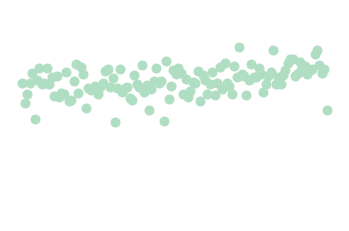

In [47]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()

x = np.arange(tmp_n)
plt.plot(x, L[:,sensor_index], 'o', color='#B0DEC3', markersize=9, label='Selected sensor signal')
# #AECCDB, #46A3CA #497FB9

# 去掉边框
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.spines['left'].set_linewidth('1.0')
#ax.spines['bottom'].set_linewidth('1.0')

# 去掉x,y轴
ax.set_xticks([])
ax.set_yticks([])

# 设置x轴显示范围
# ax.set_xlim(-2.0,164)
ax.set_ylim(-1.6, 2.0)


plt.savefig('unit4-1', bbox_inches='tight', dpi=1500, transparent=True)
plt.show()

In [53]:
obv_index1 = np.array(np.where(R>Th)).reshape(-1)
obv_index2 = np.array(np.where(R<=Th)).reshape(-1)

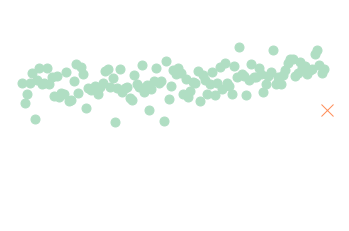

In [57]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()

plt.plot(obv_index1, L[obv_index1,sensor_index], 'x', color='#FF8D57', markersize=12, label='Outlier')
plt.plot(obv_index2, L[obv_index2,sensor_index], 'o', color='#B0DEC3', markersize=9, label='Selected sensor signal')
# #AECCDB, #46A3CA #497FB9

# 去掉边框
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


#ax.spines['left'].set_linewidth('1.0')
#ax.spines['bottom'].set_linewidth('1.0')

# 去掉x,y轴
ax.set_xticks([])
ax.set_yticks([])

# 设置x轴显示范围
# ax.set_xlim(-2.0,164)
ax.set_ylim(-1.6, 2.0)


plt.savefig('unit4-2', bbox_inches='tight', dpi=1500, transparent=True)
plt.show()

In [58]:
K = 200
gamma_samples = np.random.multivariate_normal(mu_j[unit_index].flatten(), cov_j[unit_index], size=K)  

sensor_path = np.zeros((K,320,6))
for k in range(K):
    sensor_path[k] = Psi[:320] @ gamma_samples[k].reshape(num_sensors,-1).T

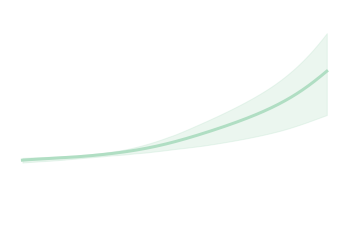

In [60]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()

plt.plot(t2[5:], sensor_path.mean(axis=0)[5:,sensor_index], color='#B0DEC3', linewidth = 3.0)
plt.fill_between(t2[5:],np.percentile(sensor_path[:,5:,sensor_index],2.5,axis=0), np.percentile(sensor_path[:,5:,sensor_index],97.5,axis=0), color='#B0DEC3', alpha=0.25)

# 去掉边框
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


#ax.spines['left'].set_linewidth('1.0')
#ax.spines['bottom'].set_linewidth('1.0')

# 去掉x,y轴
ax.set_xticks([])
ax.set_yticks([])

# 设置x轴显示范围
# ax.set_xlim(-2.0,164)
ax.set_ylim(-1.6, 6)


plt.savefig('unit4-4', bbox_inches='tight', dpi=1500, transparent=True)
plt.show()

In [64]:
x_i.shape

(6,)

In [65]:
K = 100 # 超参数
X_test = np.zeros((K, Psi.shape[0], num_sensors))

gamma_samples = np.random.multivariate_normal(mu_j[unit_index].flatten(), cov_j[unit_index], size=K)    
for k in range(K):
    X_test[k] = Psi @ gamma_samples[k].reshape(num_sensors,-1).T

p = np.zeros((K, Psi.shape[0]))
for k in range(K):
    x_i = X_test[k]
    p[k] = model2.predict_proba(x_i)[:,1]
pp = p.mean(axis=0)
tmp_n = test_lengths[i]
p_T = (pp - pp[tmp_n])/(1 - pp[tmp_n])

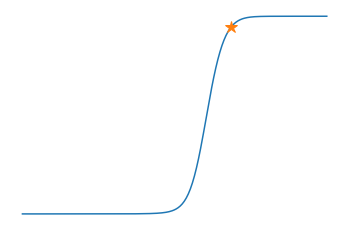

In [80]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()

x = np.arange(300)
plt.plot(x,pp[:300])
plt.plot(np.where(p_T > 0.5)[0][0],pp[np.where(p_T > 0.5)[0][0]],'*',markersize=12)

# 去掉边框
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


#ax.spines['left'].set_linewidth('1.0')
#ax.spines['bottom'].set_linewidth('1.0')

# 去掉x,y轴
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('CDF of RUL.png', bbox_inches='tight', dpi=1500, transparent=True)
plt.show()

In [66]:
p_T

array([-7.27364954, -7.27412297, -7.27412575, -7.27412152, -7.27411737,
       -7.27411362, -7.27411018, -7.27410699, -7.27410399, -7.27410112,
       -7.27409835, -7.27409564, -7.27409296, -7.2740903 , -7.27408763,
       -7.27408495, -7.27408224, -7.27407948, -7.27407668, -7.27407382,
       -7.27407088, -7.27406788, -7.2740648 , -7.27406163, -7.27405836,
       -7.274055  , -7.27405153, -7.27404796, -7.27404426, -7.27404044,
       -7.27403649, -7.27403241, -7.27402818, -7.2740238 , -7.27401926,
       -7.27401455, -7.27400967, -7.27400461, -7.27399936, -7.2739939 ,
       -7.27398824, -7.27398235, -7.27397623, -7.27396986, -7.27396324,
       -7.27395634, -7.27394917, -7.27394169, -7.2739339 , -7.27392578,
       -7.2739173 , -7.27390847, -7.27389924, -7.27388961, -7.27387954,
       -7.27386902, -7.27385802, -7.27384651, -7.27383446, -7.27382185,
       -7.27380864, -7.27379479, -7.27378027, -7.27376503, -7.27374904,
       -7.27373224, -7.2737146 , -7.27369604, -7.27367653, -7.27

In [34]:
np.save('test_mu_svgd.npy',mu_j)
np.save('test_cov_svgd.npy',cov_j)

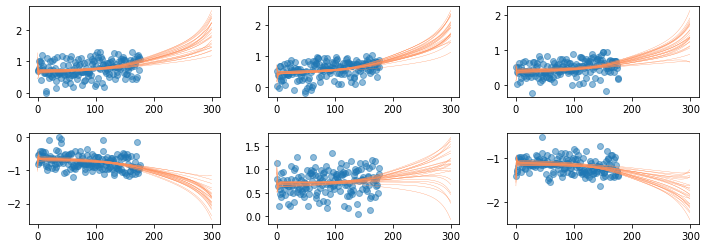

In [270]:
index, K, valid_len = 88, 25, 300
sensor_data = test_data[index]
tmp_Psi = Psi[:valid_len]
gamma_samples = np.random.multivariate_normal(mu_j[index].flatten(), cov_j[index], size=K)

fig = plt.figure(figsize=(12,4))

for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha = 0.5)
    for k in range(K):
        sensor_path = tmp_Psi @ gamma_samples[k].reshape(num_sensors,-1).T
        plt.plot(sensor_path[:,i], color='#FF8D57', linewidth=0.3)
        
plt.subplots_adjust(wspace = 0.25, hspace = 0.4)
plt.show()

In [33]:
def RMSE(true_RUL, pred_RUL):
    d = true_RUL - pred_RUL
    return np.sqrt(np.power(d,2).mean())

def score(true_RUL, pred_RUL):
    d = pred_RUL - true_RUL
    n = len(true_RUL)
    score = np.zeros(n)
    for i in range(n):
        d_i = d[i]
        if d_i >= 0:
            score[i] = np.exp(d_i/10) - 1
        elif d_i < 0:
            score[i] = np.exp(-d_i/13) - 1
    return score.sum()

In [271]:
results1 = np.zeros(50)
results2 = np.zeros(50)
results3 = np.zeros(50)

for l in range(50):
    # 设置特征值
    K = 100 # 超参数
    X_test = np.zeros((num_test, K, Psi.shape[0], num_sensors))
    for i in range(num_test):
        gamma_samples = np.random.multivariate_normal(mu_j[i].flatten(), cov_j[i], size=K)    
        for k in range(K):
            X_test[i,k] = Psi @ gamma_samples[k].reshape(num_sensors,-1).T
            
    pred_RUL = np.zeros(num_test)

    for i in range(num_test):
        p = np.zeros((K, Psi.shape[0]))
        for k in range(K):
            x_i = X_test[i,k]
            p[k] = model2.predict_proba(x_i)[:,1]
        pp = p.mean(axis=0)
        tmp_n = test_lengths[i]
        p_T = (pp - pp[tmp_n])/(1 - pp[tmp_n])
        pred_RUL[i] = np.where(p_T > 0.5)[0][0] - tmp_n
        
    df_RUL = pd.read_csv('RUL_FD001.txt',names=['true_RUL'])
    df_RUL['pred_RUL'] = pred_RUL
    df_RUL['lifetime'] = df_RUL['true_RUL'] + test_lengths
    df_RUL['error'] = np.abs(df_RUL['true_RUL']-df_RUL['pred_RUL'])/df_RUL['lifetime']
    results1[l] = df_RUL['error'].mean()
    results2[l] = RMSE(df_RUL['true_RUL'], df_RUL['pred_RUL'])
    results3[l] = score(df_RUL['true_RUL'], df_RUL['pred_RUL'])

In [272]:
results1.mean(), results1.std()

(0.06422479301729409, 0.0006174969416445025)

In [273]:
results2.mean(), results2.std()

(17.517207450645795, 0.1607579890379671)

In [37]:
results3.mean(), results3.std()

(3014965998.407418, 199321549.87686387)

In [51]:
df_RUL.head(10)

,true_RUL,pred_RUL,lifetime,error
0,112,144.0,143,0.223776
1,98,122.0,147,0.163265
2,69,55.0,195,0.071795
3,82,76.0,188,0.031915
4,91,96.0,189,0.026455
5,93,118.0,198,0.126263
6,91,96.0,251,0.019920
7,95,101.0,261,0.022989
8,111,146.0,166,0.210843
9,96,77.0,288,0.065972
